# 1. 데이터 불러오기

In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [47]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [48]:
df = train
# 1. 불필요한 열 제거
df_cleaned = df.drop(columns=['ID', '시술 시기 코드'])

# 2. 결측치 처리 (NaN 값 확인)
missing_values = df_cleaned.isnull().sum()

# 결측치가 많은 열 확인
missing_columns = missing_values[missing_values > 0]

# 결측치 비율 확인
missing_ratio = (missing_columns / len(df_cleaned)) * 100

# 결측치 비율이 30% 이상인 열 제거
drop_cols = missing_ratio[missing_ratio > 30].index
df_cleaned = df_cleaned.drop(columns=drop_cols)

# 남은 결측치는 최빈값 또는 중앙값으로 채우기
for col in df_cleaned.columns:
    if df_cleaned[col].dtype == 'object':  # 범주형 데이터는 최빈값으로 채움
        df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)
    else:  # 수치형 데이터는 중앙값으로 채움
        df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)

# 3. 범주형 데이터 인코딩 (Label Encoding 적용)
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    label_encoders[col] = le

# 4. 수치형 데이터 정규화 (Min-Max Scaling 대신 직접 정규화)
numerical_columns = df_cleaned.select_dtypes(include=['int64', 'float64']).columns.drop('임신 성공 여부')

# 직접 Min-Max 정규화 수행
for col in numerical_columns:
    min_val = df_cleaned[col].min()
    max_val = df_cleaned[col].max()
    if min_val != max_val:  # 정규화 가능할 경우만 수행
        df_cleaned[col] = (df_cleaned[col] - min_val) / (max_val - min_val)

# 5. 타겟 변수 확인 및 분포 분석
target_distribution = df_cleaned['임신 성공 여부'].value_counts(normalize=True)


C:\Users\hyunji\AppData\Local\Temp\ipykernel_4056\1917757408.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)
C:\Users\hyunji\AppData\Local\Temp\ipykernel_4056\1917757408.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

In [49]:
df_cleaned.head()

,시술 당시 나이,시술 유형,특정 시술 유형,배란 자극 여부,배란 유도 유형,단일 배아 이식 여부,착상 전 유전 진단 사용 여부,남성 주 불임 원인,남성 부 불임 원인,여성 주 불임 원인,...,난자 기증자 나이,정자 기증자 나이,동결 배아 사용 여부,신선 배아 사용 여부,기증 배아 사용 여부,대리모 여부,난자 채취 경과일,난자 혼합 경과일,배아 이식 경과일,임신 성공 여부
0,0,1,4,1.0,0,0.0,0.0,0.0,0.0,0.0,...,4,6,0.0,1.0,0.0,0.0,0.0,0.0,0.428571,0
1,5,1,4,0.0,3,0.0,0.0,0.0,0.0,0.0,...,4,6,0.0,1.0,0.0,0.0,0.0,0.0,0.428571,0
2,0,1,15,1.0,0,0.0,0.0,0.0,0.0,0.0,...,4,6,0.0,1.0,0.0,0.0,0.0,0.0,0.285714,0
3,1,1,4,1.0,0,0.0,0.0,0.0,0.0,0.0,...,4,6,0.0,1.0,0.0,0.0,0.0,0.0,0.428571,0
4,0,1,4,1.0,0,0.0,0.0,0.0,0.0,0.0,...,4,6,0.0,1.0,0.0,0.0,0.0,0.0,0.428571,0


# 2. 데이터 분할 

In [50]:
from sklearn.model_selection import train_test_split

# 입력 데이터(X)와 타겟 변수(y) 분리
X = df_cleaned.drop(columns=['임신 성공 여부'])
y = df_cleaned['임신 성공 여부']

# 80% 훈련 데이터, 20% 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# 3. XGBoost로 특성 중요도 추출

In [51]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


font_path = r'C:\Windows\Fonts\malgun.ttf'  # 또는 맑은 고딕 경로
font_prop = fm.FontProperties(fname=font_path)

# matplotlib에 폰트 적용
plt.rcParams['font.family'] = font_prop.get_name()

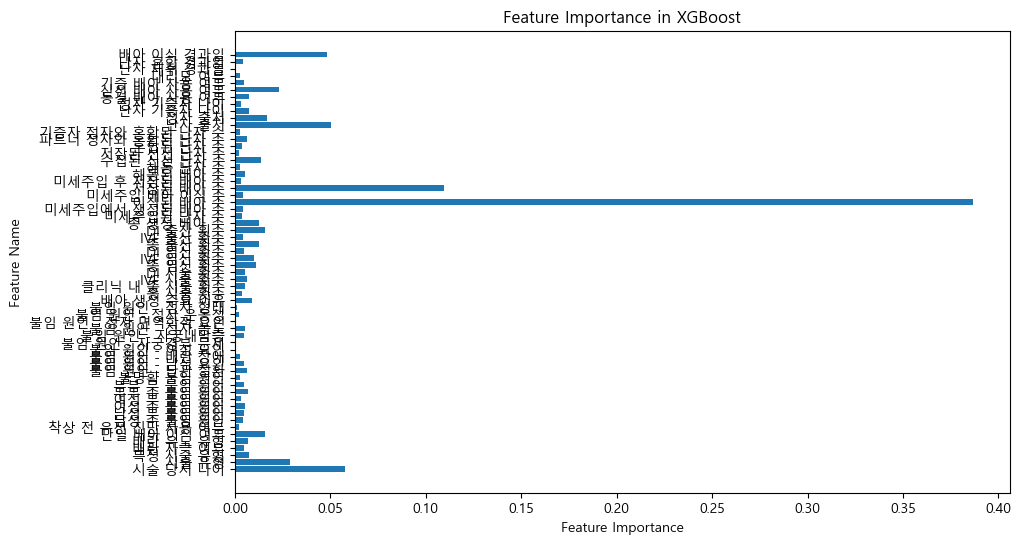

In [52]:
from xgboost import XGBClassifier


# 모델 학습
xgb_model = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)

# Feature 중요도 확인
importances = xgb_model.feature_importances_
feature_names = X_train.columns

# 상위 중요도 높은 변수만 선택
threshold = np.median(importances)  # 중요도가 중간 이하인 변수 제거
selected_features = feature_names[importances > threshold]

# 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance in XGBoost")
plt.show()


In [53]:
# Feature 중요도 확인
importances = xgb_model.feature_importances_
feature_names = X_train.columns

In [54]:
# 중요도 기준 설정 (중앙값을 기준으로 중요도가 낮은 변수 제거)
threshold = np.median(importances)  # 중요도가 중간 이하인 변수 제거
selected_features = feature_names[importances > threshold]

In [55]:
print(selected_features) 
print(len(selected_features))

Index(['시술 당시 나이', '시술 유형', '특정 시술 유형', '배란 자극 여부', '배란 유도 유형', '단일 배아 이식 여부',
       '여성 주 불임 원인', '부부 주 불임 원인', '불임 원인 - 난관 질환', '불임 원인 - 정자 농도',
       '배아 생성 주요 이유', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수', '총 임신 횟수',
       'IVF 임신 횟수', '총 출산 횟수', 'DI 출산 횟수', '총 생성 배아 수', '이식된 배아 수', '저장된 배아 수',
       '해동된 배아 수', '수집된 신선 난자 수', '파트너 정자와 혼합된 난자 수', '난자 출처', '정자 출처',
       '난자 기증자 나이', '동결 배아 사용 여부', '신선 배아 사용 여부', '배아 이식 경과일'],
      dtype='object')
30


-----------------
# 상관관계 분석

In [56]:
# 상관계수 행렬 계산
corr_matrix = df_cleaned.corr().abs()

# 상관관계가 높은 변수 찾기
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

# 상관관계가 높은 변수 제거
df_cleaned.drop(columns=to_drop, inplace=True)

# 이상치 처리

In [57]:
# numerical_columns 중 실제 존재하는 컬럼만 유지
numerical_columns = [col for col in numerical_columns if col in df_cleaned.columns]

# 다시 IQR 계산 수행
Q1 = df_cleaned[numerical_columns].quantile(0.25)
Q3 = df_cleaned[numerical_columns].quantile(0.75)
IQR = Q3 - Q1


In [58]:
# IQR 범위를 벗어나는 이상치 제거
df_cleaned = df_cleaned[~((df_cleaned[numerical_columns] < (Q1 - 1.5 * IQR)) | 
                          (df_cleaned[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [59]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# SMOTE 적용 전 클래스 분포 확인
print("Before SMOTE:", Counter(y_train))

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# SMOTE 적용 후 클래스 분포 확인
print("After SMOTE:", Counter(y_train_resampled))


Before SMOTE: Counter({0: 152098, 1: 52982})
After SMOTE: Counter({1: 152098, 0: 152098})


In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 랜덤 포레스트 모델 생성 및 학습
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"랜덤 포레스트 모델 정확도: {accuracy:.4f}")


랜덤 포레스트 모델 정확도: 0.7432


In [61]:
# XGBoost 모델 학습 (SMOTE 적용 후)
xgb_model = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

# 예측 및 평가
y_pred_smote = xgb_model.predict(X_test)
accuracy_smote = accuracy_score(y_test, y_pred_smote)

print(f"SMOTE 적용 후 XGBoost 모델 정확도: {accuracy_smote:.4f}")


SMOTE 적용 후 XGBoost 모델 정확도: 0.7249


In [62]:
import xgboost
print("XGBoost 버전:", xgboost.__version__)


XGBoost 버전: 2.1.4


In [63]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split

# 샘플 데이터 생성
X = np.random.rand(1000, 10)
y = np.random.randint(0, 2, 1000)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# GPU를 사용하는 XGBoost 모델 학습
params = {
    "objective": "binary:logistic",
    "tree_method": "gpu_hist",  # GPU 사용 설정
    "predictor": "gpu_predictor"
}

dtrain = xgb.DMatrix(X_train, label=y_train)
gpu_model = xgb.train(params, dtrain, num_boost_round=100)

print("✅ XGBoost가 GPU에서 정상적으로 실행됨!")


c:\Users\hyunji\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:02:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\hyunji\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:02:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


✅ XGBoost가 GPU에서 정상적으로 실행됨!


In [66]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'tree_method': ['gpu_hist']  # GPU 활성화
}

# GridSearchCV 실행 (GPU 사용)
grid_search = GridSearchCV(
    XGBClassifier(random_state=42), 
    param_grid, 
    cv=3, 
    scoring='accuracy', 
    n_jobs=-1
)

# 모델 학습
grid_search.fit(X_train, y_train)

# 최적 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)
best_xgb = grid_search.best_estimator_

# 최적 모델로 예측 및 평가
y_pred_best = best_xgb.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)

print(f"GPU 사용한 최적 XGBoost 모델 정확도: {accuracy_best:.4f}")



c:\Users\hyunji\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:03:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'tree_method': 'gpu_hist'}
GPU 사용한 최적 XGBoost 모델 정확도: 0.4950


c:\Users\hyunji\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:03:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
